In [391]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
%matplotlib inline

In [392]:
#all long sentence (hard to interpret comment) columns are removed
#all heavily skewed boolean columns are removed
#all obvious collinear columns are removed 
#all dates, indices, URLs columns are removed
#all columns missing over 50% of their values are removed

In [393]:
#df1= pd.read_csv('c:/users/hajyhass/downloads/seattledata/calendar.csv')
df2 =pd.read_csv('downloads/seattledata/listings.csv')
#df3 =pd.read_csv('c:/users/hajyhass/downloads/seattledata/reviews.csv')
#df4 =pd.read_csv('c:/users/hajyhass/downloads/bostondata/calendar.csv')
#df5 =pd.read_csv('c:/users/hajyhass/downloads/bostondata/listings.csv')
#df6 =pd.read_csv('c:/users/hajyhass/downloads/bostondata/reviews.csv')

In [394]:
df2.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


# Preprocessing

In [395]:
# remove any row that does not have a corresponding value for "price" and "host_since"
# the logic is that "price" will be the dependend variable of the future model so cannot carry missing values
# host_since is also a critical independent value, from which I will derive other important features, so it cannot carry missing values
df2.dropna(subset=['price','host_since'], inplace=True, axis=0)

## converting "t" and "f" values to True and False

In [396]:
df2.replace('t',True, inplace=True)
df2.replace('f',False, inplace=True)
df2
boolean_list = df2.select_dtypes(include=['bool']).columns

## converting strings to date type, and creating a new feature called "legacy"

In [397]:
def obj_to_date_convertor(date_associated_columns):
    for item in date_associated_columns:
        df2[item] = pd.to_datetime(df2[item])
    
date_associated_columns = ['host_since', 'first_review','last_review','last_scraped','calendar_last_scraped']
obj_to_date_convertor(date_associated_columns)


#extracting the latest date registered in the system
max_registered_date = max(df2[['host_since', 'first_review','last_review','last_scraped','calendar_last_scraped']].max(axis=0))

#creating a "legacy" feature, which measures the experience of a host
df2['host_legacy'] = max_registered_date - df2['host_since']
df2['host_legacy'] = df2['host_legacy'].dt.days.astype('int')

## deal with deceptive strings that must actually be int and float form

In [398]:
# extracting numerical features
num_list = df2.select_dtypes(include=['float','int']).columns
num_list

Index(['host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'bathrooms', 'bedrooms', 'beds', 'square_feet',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'reviews_per_month', 'host_legacy'],
      dtype='object')

In [399]:
# deceptive strings that must actually become float or int
deceptive_list = ['price','weekly_price','monthly_price',
                  'security_deposit','cleaning_fee','extra_people',
                  'host_acceptance_rate','host_response_rate']
for item in deceptive_list:  
    if df2[item].str.contains('%').any():   #fixing the columns containing "%" sign
        df2[item].fillna('-1%',inplace=True)
        df2[item] = df2[item].apply(lambda x: float(x.split('%')[0]))
        df2[item][df2[item]==-1] = np.NAN
    else:                                    #fixing the columns containing "$" sign
        df2[item].fillna('$-1',inplace=True)  
        df2[item] = df2[item].apply(lambda x: float(x[1:].split(',')[0]+ x[1:].split(',')[1]) if (',' in x) else float(x[1:]))
        df2[item][df2[item]==-1] = np.NAN
 

C:\Users\hajyhass\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\hajyhass\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [400]:

df2[['host_acceptance_rate','weekly_price']]

,host_acceptance_rate,weekly_price
0,100.0,NaN
1,100.0,1000.0
2,100.0,NaN
3,NaN,650.0
4,NaN,NaN
...,...,...
3813,100.0,NaN
3814,100.0,NaN
3815,NaN,450.0
3816,NaN,NaN


## weekly_price and monthly_price show strong collinearity. Therefore, I get rid of the one with more missing data. This is because of my plan to run linear regression model eventually; otherwise collinearity is not a concern for every machine learning model

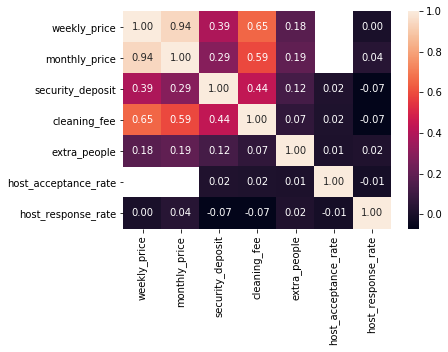

In [401]:
deceptive_list.remove('price')
# for item in deceptive_list:
#     df2_tempi = df2.dropna(subset=[item], axis=0)
#     plt.scatter(df2_tempi['price'],df2_tempi[item])
#     plt.title('price vs '+str(item))
#     plt.show()
#     print(np.corrcoef(df2_tempi['price'],df2_tempi[item]))
#     del df2_tempi
sns.heatmap(df2[deceptive_list].corr(), annot=True, fmt=".2f");

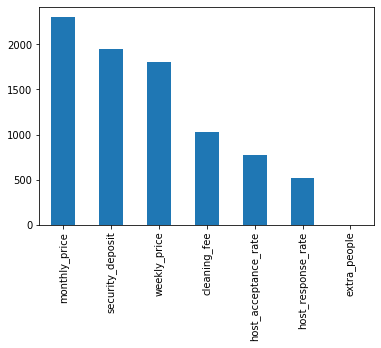

In [402]:
df2[deceptive_list].isnull().sum().sort_values(ascending=False).plot(kind='bar')

##  deceptives requiring vertical interpolation

In [403]:
vertical_deceptive_list = ['price','cleaning_fee','extra_people','host_acceptance_rate','host_response_rate']
for item in vertical_deceptive_list:
    df2[item].fillna(df2[item].mean(skipna=True), inplace=True)

##  deceptives requiring horizontal interpolation

In [404]:
horizontal_deceptive_list = ['weekly_price','monthly_price','security_deposit']
multiplier= [7,30,2] #weekly_price,monthly_price and security_deposit are all some derivative of price
for item,mult in zip(horizontal_deceptive_list,multiplier):
    
    df2[item].fillna(df2['price']*mult, inplace=True)

## Still the only strong collinearity exists between weekly_price and monthly_price; but the horizontal interpolation process did not cause new collinearities to develop

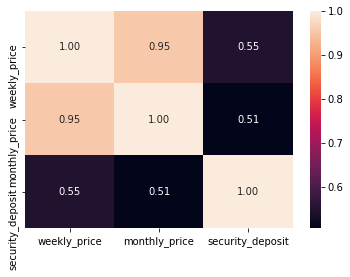

In [405]:
sns.heatmap(df2[horizontal_deceptive_list].corr(), annot=True, fmt=".2f");

## creating amenities count and host_verifications count features

In [406]:
df2['amenities_count'] = df2['amenities'].apply(lambda x: len(x.split(',')))
df2['host_verifications_count'] = df2['host_verifications'].apply(lambda x: len(x.split(',')))

## any collinearity among accommodates, bathrooms, bedrooms, beds? accomodates is highly correlated and therefore redundant

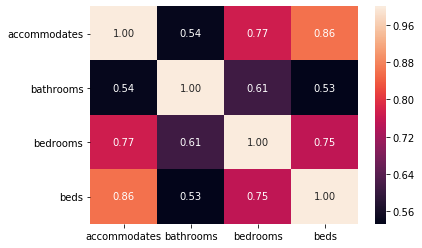

In [407]:
sns.heatmap(df2[['accommodates','bathrooms','bedrooms','beds']].corr(), annot=True, fmt=".2f");

# removal list

In [408]:
# collienar columns 
list_1 =  ['monthly_price','accommodates','host_listings_count']
list_1


['monthly_price', 'accommodates', 'host_listings_count']

In [409]:
# identify columns originally missing over 50% of their values
df2_copy =pd.read_csv('downloads/seattledata/listings.csv')
list_2 = df2_copy.columns[df2_copy.isnull().sum()/len(df2_copy)>0.50]
del df2_copy

list_2= list_2.tolist()
list_2


['square_feet', 'monthly_price', 'security_deposit', 'license']

In [410]:
# identify boolean columns with heavy skew  
df2_copy = df2[boolean_list]
list_3 = df2_copy.columns[(df2[boolean_list].sum()/len(df2)<0.05) | (df2[boolean_list].sum()/len(df2)>0.95)]
del df2_copy

list_3 = list_3.tolist()
list_3

['host_has_profile_pic', 'has_availability', 'requires_license']

In [411]:
# identify the redundant date related columns
list_4 = date_associated_columns
list_4

['host_since',
 'first_review',
 'last_review',
 'last_scraped',
 'calendar_last_scraped']

In [412]:
# identify the redundant dictionary columns
list_5 = ['amenities','host_verifications']
list_5

['amenities', 'host_verifications']

In [413]:
master_list=[]
columns_to_remove=[]
for i in range(1,6):
    master_list.append('list_'+str(i))
import ast
columns_to_remove = [eval(elem) for elem in master_list]
#Below, flatteing a list of list
flattened_list = [item for sublist in columns_to_remove for item in sublist]

del columns_to_remove
del master_list
unique_columns = list(set(flattened_list))
print(unique_columns)
#https://stackabuse.com/python-how-to-flatten-list-of-lists/

['monthly_price', 'requires_license', 'first_review', 'host_has_profile_pic', 'host_listings_count', 'host_since', 'amenities', 'last_review', 'security_deposit', 'accommodates', 'has_availability', 'calendar_last_scraped', 'host_verifications', 'license', 'square_feet', 'last_scraped']


In [414]:
df2.drop(unique_columns,axis=1,inplace=True)

## removing irrelevant numerical columns

In [415]:
df2.select_dtypes(include=['float','int','int64']).columns

Index(['id', 'scrape_id', 'host_id', 'host_response_rate',
       'host_acceptance_rate', 'host_total_listings_count', 'latitude',
       'longitude', 'bathrooms', 'bedrooms', 'beds', 'price', 'weekly_price',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'reviews_per_month', 'host_legacy', 'amenities_count',
       'host_verifications_count'],
      dtype='object')

In [416]:
df2.drop(['id','scrape_id','host_id','latitude','longitude'],axis=1, inplace=True)

## removing the irrelevant object columns

In [417]:
df2.select_dtypes(include=['object']).columns

Index(['listing_url', 'name', 'summary', 'space', 'description',
       'experiences_offered', 'neighborhood_overview', 'notes', 'transit',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_url', 'host_name', 'host_location', 'host_about',
       'host_response_time', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'street', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city',
       'state', 'zipcode', 'market', 'smart_location', 'country_code',
       'country', 'property_type', 'room_type', 'bed_type', 'calendar_updated',
       'jurisdiction_names', 'cancellation_policy'],
      dtype='object')

In [418]:
df2.drop(['listing_url', 'name', 'summary', 'space', 'description',
       'experiences_offered', 'neighborhood_overview', 'notes', 'transit',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_url', 'host_name', 'host_location', 'host_about',
       'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'street', 'neighbourhood',
       'neighbourhood_cleansed', 'city',
       'state', 'zipcode', 'market', 'smart_location', 'country_code',
       'country',
       'jurisdiction_names'],axis=1,inplace=True)

## final cleaning and one hot encoding of the categoricals

In [419]:
df2.isnull().sum()


host_response_time                  521
host_response_rate                    0
host_acceptance_rate                  0
host_is_superhost                     0
host_total_listings_count             0
host_identity_verified                0
neighbourhood_group_cleansed          0
is_location_exact                     0
property_type                         1
room_type                             0
bathrooms                            16
bedrooms                              6
beds                                  1
bed_type                              0
price                                 0
weekly_price                          0
cleaning_fee                          0
guests_included                       0
extra_people                          0
minimum_nights                        0
maximum_nights                        0
calendar_updated                      0
availability_30                       0
availability_60                       0
availability_90                       0


In [420]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:

    1. Create X as independent varibles
    2. Create y as the response variable 
    3. For each numeric variable in X, fill the column with the mean value of the column.
    4. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    
    y = df['price']
    
    #Drop price column from independent variables
    df = df.drop(['price'], axis=1)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int','int64']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y
    
#Use the function to create X and y
X, y = clean_data(df2)    

## things look fine on the surface

In [421]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state =222)
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train,y_train)
y_train_pred = lm_model.predict(X_train)
y_test_pred = lm_model.predict(X_test)

print("The  training r^2  of: {} vs The predictive r^2 of: {} on {} data points".format(r2_score(y_train,y_train_pred),r2_score(y_test,y_test_pred),len(y_test)))


The  training r^2  of: 0.9498857991696591 vs The predictive r^2 of: 0.9433184666859102 on 764 data points


## calendar_updated_13 month ago contributes much  more to the model than calendar updated_11 month ago? But why? Logically the model should not be so sensitive to calendar updates differing by a few months. The real cause of the issue is that the calendar_updates column has too many categories and there are not sufficient instances of data to meaningfully learn from those (newly one hot encoded) attributes 

In [422]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    #coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df['contribution'] = np.abs(lm_model.coef_)/sum(np.abs(lm_model.coef_))
    coefs_df = coefs_df.sort_values('contribution', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

coef_df.head(40)

,est_int,coefs,contribution
78,calendar_updated_13 months ago,91.224045,0.217460
90,calendar_updated_30 months ago,-20.957149,0.049958
98,calendar_updated_6 months ago,14.100361,0.033612
61,property_type_Dorm,-12.840318,0.030609
67,property_type_Treehouse,12.300728,0.029322
59,property_type_Chalet,10.466605,0.024950
95,calendar_updated_5 months ago,9.365523,0.022325
65,property_type_Tent,-9.167894,0.021854
73,bed_type_Pull-out Sofa,-8.888148,0.021188
76,calendar_updated_11 months ago,8.574739,0.020440


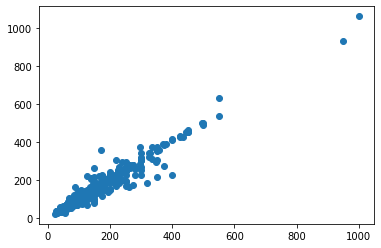

In [423]:
plt.scatter(y_test,y_test_pred)

In [426]:
df2_temp = pd.read_csv('downloads/seattledata/listings.csv')
df2_temp.dropna(subset=['price','host_since'],axis=0, inplace=True)
recent = ['today','yesterday','a week ago',' days ago']
less_than_two_months = [' weeks ago']
too_old = [' months ago','never']

contains = [df2_temp['calendar_updated'].str.contains(item) for item in recent]
df2_temp[np.any(contains, axis=0)] ="recently"
contains = [df2_temp['calendar_updated'].str.contains(item) for item in less_than_two_months]
df2_temp[np.any(contains, axis=0)] ="within_last_two_months"
contains = [df2_temp['calendar_updated'].str.contains(item) for item in too_old]
df2_temp[np.any(contains, axis=0)] ="never_or_over_two_months_ago"
df2['calendar_updated'] = df2_temp['calendar_updated']
del df2_temp
# df2_temp['calendar_updated']
# df2_temp['calendar_updated'].head(30)

In [427]:
#import fnmatch
#new_removal_list = fnmatch.filter(X.columns, 'calendar_updated*')
#new_removal_list
#X.drop(new_removal_list,axis=1,inplace=True)


In [428]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:

    1. Create X as independent varibles
    2. Create y as the response variable 
    3. For each numeric variable in X, fill the column with the mean value of the column.
    4. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    
    y = df['price']
    
    #Drop price column from independent variables
    df = df.drop(['price'], axis=1)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int','int64']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y
    
#Use the function to create X and y
X, y = clean_data(df2)    

In [429]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state =222)
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train,y_train)
y_train_pred = lm_model.predict(X_train)
y_test_pred = lm_model.predict(X_test)

print("The  training r^2  of: {} vs The predictive r^2 of: {} on {} data points".format(r2_score(y_train,y_train_pred),r2_score(y_test,y_test_pred),len(y_test)))


The  training r^2  of: 0.9491789514751476 vs The predictive r^2 of: 0.9436330226052424 on 764 data points


In [436]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    #coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df['contribution'] = np.abs(lm_model.coef_)/sum(np.abs(lm_model.coef_))
    coefs_df['total contribution'] = coefs_df['contribution'].sum()
    coefs_df = coefs_df.sort_values('contribution', ascending=False)
    
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

coef_df.tail(40)

,est_int,coefs,contribution,total contribution
62,property_type_House,1.024245,0.005664,1.0
78,cancellation_policy_moderate,0.886520,0.004902,1.0
8,beds,0.870699,0.004815,1.0
25,review_scores_location,-0.859636,0.004754,1.0
40,neighbourhood_group_cleansed_Cascade,-0.853460,0.004720,1.0
11,guests_included,0.838788,0.004639,1.0
35,host_response_time_within a day,0.819228,0.004530,1.0
4,host_identity_verified,0.772019,0.004269,1.0
31,reviews_per_month,-0.570087,0.003153,1.0
56,property_type_Bungalow,0.534386,0.002955,1.0


## The latter model is superior to the one preceeding it. The latter does not over-rely on random categorical values of calendar_updated. The aggregate contribution of calendar_updated derivatives is reduced here (from 40% to under 10%). This means the latter model captures the properties of other features as well to generate forecasts that are as accurate. I speculate, that shortage of instances has caused the former model to naturally get overfit. To remedy,1- I could expand my dataset, 2-Introduce L1 lasso or L2 ridge regularizors to control the overfitting 3-Perform Cross Validation.....I speculate the former model was overfit, due to learning from noise of the calendar_updated derivatives. By collapsing the feature categories into a smaller set, I reduce the possibility of noise learning, this is what essentially L1 Lasso achieves; eliminating the irrelevant columns by penalization.